In [542]:
import matplotlib.pyplot as plt
import numpy as np

# Load trajectory and keyframes
traj = np.loadtxt("test_data/test_traj.csv", delimiter=",", dtype=float)
keys = np.loadtxt("test_data/pos_keyframes.csv", delimiter=",", dtype=float)

# Split up trajectory data
t  = traj[:,0].reshape(-1,1)
x  = traj[:,1].reshape(-1,1);   y  = traj[:,2].reshape(-1,1);   z  = traj[:,3].reshape(-1,1);   yaw  = traj[:,4].reshape(-1,1);      # position
vx = traj[:,5].reshape(-1,1);   vy = traj[:,6].reshape(-1,1);   vz = traj[:,7].reshape(-1,1);   vyaw = traj[:,8].reshape(-1,1);      # velocity
ax = traj[:,9].reshape(-1,1);   ay = traj[:,10].reshape(-1,1);  az = traj[:,11].reshape(-1,1);  ayaw = traj[:,12].reshape(-1,1);     # acceleration
jx = traj[:,13].reshape(-1,1);  jy = traj[:,14].reshape(-1,1);  jz = traj[:,15].reshape(-1,1);  jyaw = traj[:,16].reshape(-1,1);     # jerk


In [543]:
# Find xb, yb, zb (as in Flatness-based Quadcopter Trajectory Planning... by Friere and Xu)

# Get zb
g = 9.81
Thrust = np.hstack((ax,ay,az+g)).T
norm_Thrust = np.linalg.norm(Thrust, axis = 0)
zb = Thrust / norm_Thrust

# Get xb
yc = np.hstack(( -np.sin(yaw), np.cos(yaw), np.zeros((t.size,1)) )).T
yc_zb = np.cross(yc, zb, axis = 0)
yc_zb_norm = np.linalg.norm(yc_zb, axis = 0)
xb = yc_zb / yc_zb_norm

# Get yb
yb = np.cross(zb, xb, axis = 0)

In [544]:
# Find roll and pitch

zw = np.array(([0],[0],[1]))
zw_yb = zw.T @ yb
zw_xb = zw.T @ xb
roll = np.arcsin(zw_yb/(np.cos(np.arcsin(zw_xb)))).T
pitch = -np.arcsin(zw_xb).T

In [545]:
# Define rotation matrix functions

Rotz = lambda ang : np.array(([np.cos(ang), -np.sin(ang), 0],
                              [np.sin(ang), np.cos(ang), 0],
                              [0, 0, 1]))
Roty = lambda ang : np.array(([np.cos(ang), 0, np.sin(ang)],
                              [0, 1, 0],
                              [-np.sin(ang), 0, np.cos(ang)]))
Rotx = lambda ang : np.array(([1, 0, 0],
                              [0, np.cos(ang), -np.sin(ang)],
                              [0, np.sin(ang), np.cos(ang)]))
Rzyx = lambda roll, pitch, yaw : Rotz(yaw) @ Roty(pitch) @ Rotx(roll)

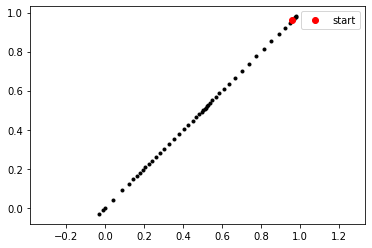

In [546]:
pos = np.hstack((x,y,z)).T
landmark = np.array(([0],[0],[0]))
p = np.empty((2, t.size))

for i in range(t.size):
    R = Rzyx(roll[i][0], pitch[i][0], yaw[i][0])
    P = R.T @ (pos[:,i].reshape(3,1) - landmark)
    p[0,i] = P[0]/(-P[2])
    p[1,i] = P[1]/(-P[2])

plt.plot(p[0,:],p[1,:],'k.')
plt.plot(p[0,0],p[1,0],'ro',label='start')
plt.legend()
plt.axis('equal')

plt.show()